In [1]:
import numpy as np
import pandas as pd
#
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
#
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('train.csv')

In [5]:
#df.describe()

### EDA

In [6]:
df['imt']=df.weight/(df.height**2)*10000

In [7]:
df.loc[df.height<100,'height'] = df[df.height<100].height+100
median_height = df.height.median()
df.loc[(df.height<100) |(df.height > 210) ,'height'] = median_height
median_weight = df.weight.median()
df.loc[df.weight<40,'weight'] = median_weight

df.loc[df.ap_hi<20,'ap_hi'] = df[df.ap_hi<20]*10
df.loc[df.ap_hi<0,'ap_hi'] = df[df.ap_hi<20]*(-1)
df.loc[df.ap_hi>300,'ap_hi'] = df[df.ap_hi>300]/10
df.loc[df.ap_hi>300,'ap_hi'] = df[df.ap_hi>300]/10
df.loc[df.ap_lo>200,'ap_lo'] = df[df.ap_lo>200]/10
df.loc[df.ap_lo>200,'ap_lo'] = df[df.ap_lo>200]/10


In [8]:
df.loc[df.ap_hi<df.ap_lo, ['ap_hi', 'ap_lo']] = df.loc[df.ap_hi<df.ap_lo, ['ap_lo', 'ap_hi']].values

In [10]:
#df.hist()

### prepare for ML

#### OHE

In [11]:
df = df.drop(['id'], axis =1)
df.gender = df.gender - 1

In [12]:
ohe_columns = ['cholesterol','gluc', ]
ohe = OneHotEncoder(sparse=False, drop = 'first')
encoded_array = ohe.fit_transform(df.loc[:,ohe_columns])
df_c = pd.DataFrame(encoded_array,columns=ohe.get_feature_names_out() )
df3 = pd.concat([df, df_c], axis=1)

In [13]:
features= df3.drop(['cardio', 'cholesterol','gluc'], axis=1)
target = df3['cardio']

#### scale

In [14]:
scale_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imt']
scaler = StandardScaler()
scaler.fit(features[scale_columns])
features_s= scaler.transform(features[scale_columns])
features_s = pd.DataFrame(features_s)
features_s.columns = scale_columns
features.drop(scale_columns, axis=1, inplace = True)
features_s = pd.concat([features_s, features], axis=1)

In [15]:
target.value_counts()
class_0_w = 1
class_1_w = len(target[target==0])/len(target[target==1])
print(class_1_w)

1.0012007204322593


### ML

In [16]:
features_s = features_s.drop(['alco', 'gluc_2'], axis=1)

In [23]:
score_max=0
for est in range(59, 61,1):
    for depth in range(12,17, 1):
        model_1 = RandomForestClassifier(class_weight={0:class_0_w,1:class_1_w},criterion='entropy', random_state=54321, n_estimators = est, max_depth=depth, min_samples_leaf=50)
        scores = cross_val_score(model_1,features_s,  target, scoring="roc_auc", cv=4)
        print("Est = %d depth = %d  AUC_ROC Score %0.5f accuracy" % ( est , depth, scores.mean()))
        if scores.mean() > score_max:
            score_max = scores.mean()
            est_max=est
            depth_max = depth
print("Maximum: est=", est_max, "depth=", depth_max,"accuracy score = ", score_max)

Est = 59 depth = 12  AUC_ROC Score 0.80207 accuracy
Est = 59 depth = 13  AUC_ROC Score 0.80184 accuracy
Est = 59 depth = 14  AUC_ROC Score 0.80205 accuracy
Est = 59 depth = 15  AUC_ROC Score 0.80209 accuracy
Est = 59 depth = 16  AUC_ROC Score 0.80183 accuracy
Est = 60 depth = 12  AUC_ROC Score 0.80209 accuracy
Est = 60 depth = 13  AUC_ROC Score 0.80187 accuracy
Est = 60 depth = 14  AUC_ROC Score 0.80206 accuracy
Est = 60 depth = 15  AUC_ROC Score 0.80213 accuracy
Est = 60 depth = 16  AUC_ROC Score 0.80186 accuracy
Maximum: est= 60 depth= 15 accuracy score =  0.8021335918514224


In [37]:
model_1 = RandomForestClassifier(class_weight={0:class_0_w,1:class_1_w},criterion='entropy', random_state=54321, n_estimators = est_max, max_depth=depth_max, min_samples_leaf=50)
model_1.fit(features_s, target)

RandomForestClassifier(class_weight={0: 1, 1: 1.0012007204322593},
                       criterion='entropy', max_depth=15, min_samples_leaf=50,
                       n_estimators=60, random_state=54321)

In [38]:
predict_p = model_1.predict_proba(features_s)
res = pd.DataFrame(predict_p[:,1])
print(roc_auc_score(target, res))

0.820682829731533


age              0.142916
height           0.017620
weight           0.035380
ap_hi            0.488841
ap_lo            0.162231
imt              0.053552
gender           0.003437
smoke            0.003347
active           0.006957
cholesterol_2    0.008421
cholesterol_3    0.070540
gluc_3           0.006758
dtype: float64


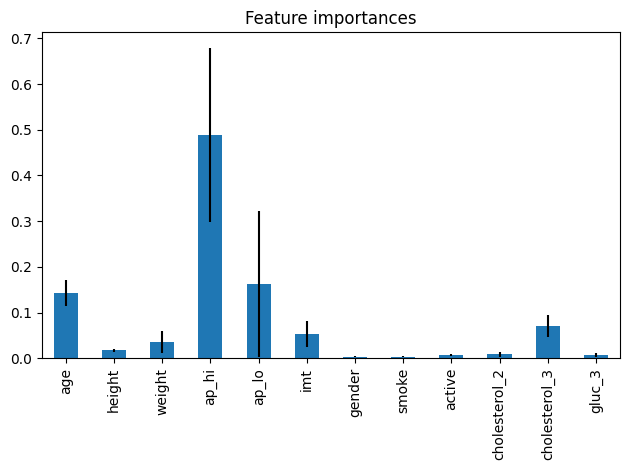

In [39]:
importances = model_1.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_1.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features_s.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("")
fig.tight_layout()
print(forest_importances)

### work with test

In [40]:
test = pd.read_csv('test.csv')

In [41]:
test['imt']=test.weight/(test.height**2)*10000
test.loc[test.height<100,'height'] = test[test.height<100].height+100
test.loc[(test.height<110) |(test.height > 210) ,'height'] = median_height
test.loc[test.weight<40,'weight'] = median_weight
test.loc[test.ap_hi<20,'ap_hi'] = test[test.ap_hi<20]*10
test.loc[test.ap_hi<0,'ap_hi'] = test[test.ap_hi<20]*(-1)
test.loc[test.ap_hi>300,'ap_hi'] = test[test.ap_hi>300]/10
test.loc[test.ap_hi>300,'ap_hi'] = test[test.ap_hi>300]/10
test.loc[test.ap_lo>200,'ap_lo'] = test[test.ap_lo>200]/10
test.loc[test.ap_lo>200,'ap_lo'] = test[test.ap_lo>200]/10
test.gender = test.gender - 1

In [42]:
test.loc[test.ap_hi<test.ap_lo, ['ap_hi', 'ap_lo']] = test.loc[test.ap_hi<test.ap_lo, ['ap_lo', 'ap_hi']].values

In [43]:
ohe_columns = ['cholesterol','gluc']
ohe = OneHotEncoder(sparse=False, drop = 'first')
encoded_array = ohe.fit_transform(test.loc[:,ohe_columns])
test2 = pd.DataFrame(encoded_array,columns=ohe.get_feature_names_out() )
test_s= scaler.transform(test[scale_columns])
test_s = pd.DataFrame(test_s)
test_s.columns = scale_columns
test.drop(scale_columns, axis=1, inplace = True)
testf = pd.concat([test, test_s], axis=1)
testf=pd.concat([testf, test2], axis=1)

In [44]:
columnsTitles = ['age','height', 'weight','ap_hi','ap_lo','imt','gender', 'smoke', 'alco','active', 'cholesterol_2','cholesterol_3','gluc_2','gluc_3']
testf2 = testf.reindex(columns=columnsTitles)

In [45]:
testf2 = testf2.drop(['alco', 'gluc_2'], axis=1)

In [46]:
predict_p = model_1.predict_proba(testf2)
#display(pd.DataFrame(model_1.predict(testf2)).value_counts())
res_p = pd.DataFrame(predict_p[:,1])
res_p.columns=(['cardio'])
res_out = pd.concat([test, res_p], axis=1)


In [47]:
display(pd.DataFrame(model_1.predict(testf2)).value_counts())

0    16255
1    13745
dtype: int64

In [48]:
res_out[['id', 'cardio']].to_csv('result_03_march-2.csv', index=False)

In [32]:
import pickle

In [34]:
f = open("model_1.bin", "wb")

In [36]:
pickle.dump( model_1, f)

In [37]:
ff = open("scaler.bin", "wb")
pickle.dump( scaler , ff)

In [41]:
###
with open("model_1.bin", "rb") as fid:
    model_l = pickle.load(fid)

EOFError: Ran out of input

In [46]:
ff = open("scaler.bin", "rb")
scaler_2 = pickle.load(ff)

In [52]:
test_s= scaler.transform(test[scale_columns])

KeyError: "None of [Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imt'], dtype='object')] are in the [columns]"

In [10]:
df[df.ap_hi<df.ap_lo]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imt
474,681,19099,1,156,65.0,120,150.0,2,1,0,0,1,0,26.709402
636,913,20457,2,169,68.0,70,110.0,1,1,0,0,1,0,23.808690
2381,3352,20994,2,186,105.0,140,1000.0,1,1,0,0,1,1,30.350330
2384,3356,23361,1,154,102.0,90,150.0,1,1,0,0,0,1,43.008939
2985,4208,20398,1,168,78.0,140,804.4,3,3,0,0,0,1,27.636054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67162,95886,18469,2,165,68.0,113,570.0,1,1,0,0,1,0,24.977043
67421,96271,23424,1,153,74.0,80,130.0,1,1,0,0,1,1,31.611773
67470,96339,21193,2,172,57.0,80,120.0,1,1,1,0,1,1,19.267171
68067,97210,18421,1,152,65.0,80,120.0,1,1,0,0,1,0,28.133657


In [7]:
df.loc[df.ap_lo>200,'ap_lo'] = df[df.ap_lo>200]/10

In [9]:
df.loc[df.ap_hi<20,'ap_hi'] = df[df.ap_hi<20]*10

In [11]:
df.loc[df.ap_hi<df.ap_lo, ['ap_hi', 'ap_lo']] =df[df.ap_hi<df.ap_lo, ['ap_lo', 'ap_hi']] 

In [12]:
df[df.ap_hi<df.ap_lo]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imt
474,681,19099,1,156,65.0,120,150.0,2,1,0,0,1,0,26.709402
636,913,20457,2,169,68.0,70,110.0,1,1,0,0,1,0,23.808690
2381,3352,20994,2,186,105.0,140,1000.0,1,1,0,0,1,1,30.350330
2384,3356,23361,1,154,102.0,90,150.0,1,1,0,0,0,1,43.008939
2985,4208,20398,1,168,78.0,140,804.4,3,3,0,0,0,1,27.636054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67162,95886,18469,2,165,68.0,113,570.0,1,1,0,0,1,0,24.977043
67421,96271,23424,1,153,74.0,80,130.0,1,1,0,0,1,1,31.611773
67470,96339,21193,2,172,57.0,80,120.0,1,1,1,0,1,1,19.267171
68067,97210,18421,1,152,65.0,80,120.0,1,1,0,0,1,0,28.133657


In [26]:
df[df.ap_hi<df.ap_lo][['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
